In [10]:
"""
Compute per-iteration durations from logs.

Definition:
- System start:
    * first log timestamp in the file (initial load), and
    * every 'system_survey_completed' (that timestamp becomes BOTH
      the previous system's end and the next system's start)
- Iteration within a system:
    * each 'image_generation_completed' event
    * duration = (generation_completed_time - system_start_time)

- System label:
    * Only known at 'system_completed' -> map it to the most recent
      finished system block whose end time is <= that event time.
    * If none matches, leave as 'unknown'.

Outputs:
  - iteration_durations.csv with columns:
    person, system_index, system_type, system_start, system_end,
    gen_index, image_timestamp, duration_seconds, image_path
"""

import json
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Optional

import pandas as pd
from zoneinfo import ZoneInfo

# ====== Config ======
BASE_DIR = Path("log")  # your log folder (e.g., ./log)
LOG_GLOB = "P*.log"  # e.g., P2.log, P3.log, ...
TZ = "Asia/Seoul"
OUT_CSV = Path("iteration_durations.csv")

# Event names
EVENT_IMAGE_DONE = "image_generation_completed"
EVENT_IMAGE_REQUESTED = "image_generation_requested"  # (optional, not required here)
EVENT_SYSTEM_SURVEY_DONE = "system_survey_completed"  # boundary between systems
EVENT_SYSTEM_COMPLETED = "system_completed"  # only source of system_type


# ====== Utilities ======
def _parse_ts(ts: str, tz: str = TZ) -> datetime:
    """Parse ISO-like timestamp to tz-aware datetime."""
    if not ts:
        raise ValueError("Empty timestamp")
    ts = ts.replace("Z", "+00:00")
    try:
        dt = datetime.fromisoformat(ts)
    except Exception:
        dt = datetime.strptime(ts, "%Y-%m-%d %H:%M:%S")
    return dt.astimezone(ZoneInfo(tz))


def _iter_log_events(path: Path):
    """Yield JSON records from a line-oriented log file that embeds a JSON object per line."""
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            i = line.find("{")
            if i == -1:
                continue
            try:
                rec = json.loads(line[i:])
            except json.JSONDecodeError:
                continue
            if isinstance(rec, dict) and "event" in rec:
                yield rec


def _get_person(rec: Dict[str, Any], fallback: str) -> str:
    return str(rec.get("user_id") or rec.get("participant") or fallback)


def _get_image_path(details: Dict[str, Any]) -> Optional[str]:
    for k in ("image_path", "image", "path", "filepath", "file"):
        v = details.get(k)
        if isinstance(v, str) and v.strip():
            return v.strip()
    return None


def _get_system_type(details: Dict[str, Any]) -> Optional[str]:
    for k in ("system_type", "system", "system_id"):
        if k in details:
            return str(details[k])
    return None


# ====== Core ======
def extract_iteration_times(log_paths: List[Path]) -> pd.DataFrame:
    """
    Build system blocks per person with:
      - start at first log timestamp or system_survey_completed
      - end at next system_survey_completed (timestamp = end)
    Record an iteration for each image_generation_completed inside the block.
    Later, attach system_type from system_completed events to the most
    recent finished block whose end <= system_completed timestamp.
    """
    # person → list of blocks, in time order
    # block = {index, start, end, gens:[{ts, path}], system_type:None}
    blocks: Dict[str, List[Dict[str, Any]]] = {}
    # person → list of (ts, system_type)
    sys_completed_events: Dict[str, List[Dict[str, Any]]] = {}

    for log_path in log_paths:
        fallback_person = log_path.stem.lower()  # e.g., "p2"
        current_block_idx_by_person: Dict[str, int] = {}
        # For each person we lazily create the first block when we see the very first event
        for rec in _iter_log_events(log_path):
            ev = rec.get("event")
            ts = _parse_ts(rec.get("timestamp") or rec.get("time") or "")
            details = rec.get("details") or {}
            person = _get_person(rec, fallback_person)

            if person not in blocks:
                # create first block starting at the timestamp of the first event
                blocks[person] = [
                    {
                        "index": 1,
                        "start": ts,
                        "end": None,
                        "gens": [],
                        "system_type": None,
                    }
                ]
                current_block_idx_by_person[person] = 1

            # current block reference
            cur_idx = current_block_idx_by_person[person]
            cur_block = next(b for b in blocks[person] if b["index"] == cur_idx)

            if ev == EVENT_IMAGE_DONE:
                img_path = _get_image_path(details)
                cur_block["gens"].append({"ts": ts, "image_path": img_path})

            elif ev == EVENT_SYSTEM_SURVEY_DONE:
                # close current block at this timestamp,
                # and immediately start next block from the same timestamp
                if cur_block["end"] is None:
                    cur_block["end"] = ts
                next_idx = cur_idx + 1
                blocks[person].append(
                    {
                        "index": next_idx,
                        "start": ts,
                        "end": None,
                        "gens": [],
                        "system_type": None,
                    }
                )
                current_block_idx_by_person[person] = next_idx

            elif ev == EVENT_SYSTEM_COMPLETED:
                # record system_type resolution event
                sys_type = _get_system_type(details) or "unknown"
                sys_completed_events.setdefault(person, []).append(
                    {"ts": ts, "system_type": sys_type}
                )

            # (optional) handle other events if needed

    # Attach system_type to finished blocks using system_completed timestamps

    # Build rows
    rows: List[Dict[str, Any]] = []
    for person, blist in blocks.items():
        # ensure blocks ordered by index
        blist_sorted = sorted(blist, key=lambda b: b["index"])
        for b in blist_sorted:
            gens_sorted = sorted(b["gens"], key=lambda g: g["ts"])
            for gi, g in enumerate(gens_sorted, start=1):
                dur = (g["ts"] - b["start"]).total_seconds()
                rows.append(
                    {
                        "person": person,
                        "system_index": b["index"],
                        "system_type": b["system_type"] or "unknown",
                        "system_start": b["start"].isoformat(),
                        "system_end": b["end"].isoformat() if b["end"] else "",
                        "gen_index": gi,
                        "image_timestamp": g["ts"].isoformat(),
                        "duration_seconds": dur,
                        "image_path": g.get("image_path"),
                    }
                )

    if not rows:
        return pd.DataFrame(
            columns=[
                "person",
                "system_index",
                "system_type",
                "system_start",
                "system_end",
                "gen_index",
                "image_timestamp",
                "duration_seconds",
                "image_path",
            ]
        )

    df = (
        pd.DataFrame(rows)
        .sort_values(["person", "system_index", "gen_index"])
        .reset_index(drop=True)
    )
    return df


def main():
    log_files = sorted((BASE_DIR).glob(LOG_GLOB))
    if not log_files:
        print(f"No logs found under {BASE_DIR} matching {LOG_GLOB}")
        return
    df = extract_iteration_times(log_files)
    df.to_csv(OUT_CSV, index=False)
    print(f"Saved: {OUT_CSV.resolve()} (rows={len(df)})")
    print(df.head(20))


if __name__ == "__main__":
    main()
    main()


Saved: /Users/jeongin/oopt/iteration_durations.csv (rows=84)
   person  system_index system_type                      system_start  \
0      P1             1     unknown  2025-08-24T11:24:06.969567+09:00   
1      P1             1     unknown  2025-08-24T11:24:06.969567+09:00   
2      P1             1     unknown  2025-08-24T11:24:06.969567+09:00   
3      P1             2     unknown  2025-08-24T11:42:40.969622+09:00   
4      P1             2     unknown  2025-08-24T11:42:40.969622+09:00   
5      P1             2     unknown  2025-08-24T11:42:40.969622+09:00   
6      P1             2     unknown  2025-08-24T11:42:40.969622+09:00   
7      P1             2     unknown  2025-08-24T11:42:40.969622+09:00   
8     P11             1     unknown  2025-08-23T08:49:54.222715+09:00   
9     P11             1     unknown  2025-08-23T08:49:54.222715+09:00   
10    P11             1     unknown  2025-08-23T08:49:54.222715+09:00   
11    P11             1     unknown  2025-08-23T08:49:54.222715

# System type is not correctly annotated. Beaware!

In [14]:
"""
Plot per-person iteration durations by system, and save system stats.

Inputs
  - iteration_durations.csv  (from your previous step)
    columns: person, system_index, system_type, system_start, system_end,
             gen_index, image_timestamp, duration_seconds, image_path

Outputs
  plots/
    person_<person>_durations_by_system_box.png     # per-person box + jitter
    system_duration_means_pooled.png                # pooled across all iterations
    system_duration_means_person_avg.png            # average of per-person means
  per_person_system_duration_stats.csv              # person×system stats
  system_stats_pooled.csv                           # pooled stats (all iterations)
  system_stats_person_avg.csv                       # per-person mean → system-level
"""

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

IN_CSV = Path("result/time/iteration_durations.csv")
PLOT_DIR = Path("result/time/plots")
PLOT_DIR.mkdir(exist_ok=True)

PER_PERSON_STATS_CSV = Path("per_person_system_duration_stats.csv")
SYSTEM_STATS_POOLED_CSV = Path("system_stats_pooled.csv")
SYSTEM_STATS_PERSONAVG_CSV = Path("system_stats_person_avg.csv")


# ---------------- Utils ----------------
def load_iteration_table(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # 기본 정리
    if "system_type" not in df.columns:
        raise ValueError("CSV must include 'system_type'.")
    df["duration_seconds"] = pd.to_numeric(df["duration_seconds"], errors="coerce")
    df = df.dropna(subset=["person", "system_type", "duration_seconds"])
    # 정렬: 사람→시스템인덱스→gen_index
    sort_cols = [c for c in ["person", "system_index", "gen_index"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols).reset_index(drop=True)
    return df


def per_person_boxplot(df: pd.DataFrame, out_dir: Path):
    """
    사람별로 system_type 카테고리의 박스플롯을 그리고,
    각 iteration을 jitter로 찍어줌.
    """
    rng = np.random.default_rng(42)

    for person, g in df.groupby("person"):
        # system_type의 순서는 '해당 사람이 경험한 system_index의 최소값'으로 정렬
        order_df = (
            g.groupby("system_type", as_index=False)["system_index"]
            .min()
            .sort_values("system_index")
        )
        systems = order_df["system_type"].tolist()

        data = [
            g.loc[g["system_type"] == s, "duration_seconds"].values for s in systems
        ]

        plt.figure(figsize=(max(6, 1.6 * len(systems)), 5))
        bp = plt.boxplot(data, patch_artist=False, labels=systems)  # 색 지정 X

        # jitter scatter (개별 iteration 점)
        for xi, s in enumerate(systems, start=1):
            y = g.loc[g["system_type"] == s, "duration_seconds"].values
            if len(y) == 0:
                continue
            xj = xi + (rng.random(len(y)) - 0.5) * 0.25  # jitter폭
            plt.plot(xj, y, "o", alpha=0.6)

        plt.ylabel("Duration (seconds)")
        plt.title(f"{person}: Iteration Durations by System")
        plt.tight_layout()
        out = out_dir / f"person_{person}_durations_by_system_box.png"
        plt.savefig(out, dpi=150)
        plt.close()
        print(f"Saved plot: {out}")


def per_person_boxplot_horizontal(df: pd.DataFrame, out_path: Path):
    """
    모든 participant의 system_type별 iteration durations를 하나의 수평 박스플롯에 그림.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    rng = np.random.default_rng(42)
    # participant-system 조합별로 박스플롯을 그림
    df_sorted = df.sort_values(["person", "system_index", "gen_index"]).copy()
    # x축: duration, y축: participant-system 조합
    df_sorted["label"] = df_sorted["person"] + " · " + df_sorted["system_type"]
    labels = df_sorted["label"].unique()
    data = [df_sorted.loc[df_sorted["label"] == lab, "duration_seconds"].values for lab in labels]
    plt.figure(figsize=(max(8, 0.6 * len(labels)), 1.2 * len(labels)))
    bp = plt.boxplot(data, vert=False, patch_artist=False, labels=labels)
    # jitter scatter (개별 iteration 점)
    for yi, lab in enumerate(labels, start=1):
        x = df_sorted.loc[df_sorted["label"] == lab, "duration_seconds"].values
        if len(x) == 0: continue
        yj = yi + (rng.random(len(x)) - 0.5) * 0.25
        plt.plot(x, yj, "o", alpha=0.6)
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Participant · System")
    plt.title("Iteration Durations by Participant and System (Horizontal Boxplot)")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()
    print(f"Saved plot: {out_path}")


def compute_stats(df: pd.DataFrame):
    """
    1) person×system별 통계
    2) 시스템별 pooled 통계 (모든 iteration 합쳐서)
    3) 시스템별 per-person 평균의 평균 (사람 단위 가중 동일)
    """
    # 1) person×system
    grp_ps = df.groupby(["person", "system_type"])["duration_seconds"]
    per_person_stats = pd.DataFrame(
        {
            "n": grp_ps.count(),
            "mean": grp_ps.mean(),
            "median": grp_ps.median(),
            "std": grp_ps.std(ddof=1),
            "sem": grp_ps.sem(ddof=1),
            "min": grp_ps.min(),
            "max": grp_ps.max(),
        }
    ).reset_index()
    per_person_stats["ci95"] = 1.96 * per_person_stats["sem"]
    per_person_stats = per_person_stats.sort_values(
        ["person", "system_type"]
    ).reset_index(drop=True)

    # 2) pooled (모든 iteration을 하나로 합쳐 system별)
    grp_sys = df.groupby("system_type")["duration_seconds"]
    pooled = pd.DataFrame(
        {
            "n": grp_sys.count(),
            "mean": grp_sys.mean(),
            "median": grp_sys.median(),
            "std": grp_sys.std(ddof=1),
            "sem": grp_sys.sem(ddof=1),
            "min": grp_sys.min(),
            "max": grp_sys.max(),
        }
    ).reset_index()
    pooled["ci95"] = 1.96 * pooled["sem"]
    pooled = pooled.sort_values("system_type").reset_index(drop=True)

    # 3) per-person mean → system-level (사람 가중 동일)
    per_person_means = (
        df.groupby(["person", "system_type"], as_index=False)["duration_seconds"]
        .mean()
        .rename(columns={"duration_seconds": "person_mean"})
    )
    grp_sys_personavg = per_person_means.groupby("system_type")["person_mean"]
    person_avg = pd.DataFrame(
        {
            "n_persons": grp_sys_personavg.count(),
            "mean_of_person_means": grp_sys_personavg.mean(),
            "std_of_person_means": grp_sys_personavg.std(ddof=1),
            "sem_of_person_means": grp_sys_personavg.sem(ddof=1),
            "min_of_person_means": grp_sys_personavg.min(),
            "max_of_person_means": grp_sys_personavg.max(),
        }
    ).reset_index()
    person_avg["ci95_of_person_means"] = 1.96 * person_avg["sem_of_person_means"]
    person_avg = person_avg.sort_values("system_type").reset_index(drop=True)

    return per_person_stats, pooled, person_avg


def plot_system_means(
    stats_df: pd.DataFrame, value_col: str, y_label: str, title: str, out_path: Path
):
    """
    시스템별 평균 막대 + 95% CI 에러바.
    stats_df는 'system_type', value_col, 'ci95*'가 있어야 함.
    """
    if stats_df.empty:
        print("No stats to plot.")
        return

    # ci 컬럼명 유추
    ci_cols = [c for c in stats_df.columns if c.lower().startswith("ci95")]
    ci_col = ci_cols[0] if ci_cols else None
    y = stats_df[value_col].to_numpy()
    x = np.arange(len(stats_df))

    plt.figure(figsize=(8, 5))
    plt.bar(x, y)
    if ci_col is not None:
        err = stats_df[ci_col].to_numpy()
        plt.errorbar(x, y, yerr=err, fmt="none", capsize=5)
    plt.xticks(x, stats_df["system_type"], rotation=0)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()
    print(f"Saved plot: {out_path}")

def per_person_cumulative_duration_lineplot_offset(df, out_path):
    import matplotlib.pyplot as plt
    import numpy as np
    df_sorted = df.sort_values(["person", "system_index", "system_type", "gen_index"]).copy()
    system_order = ["system1", "system2"]  # 실제 값에 맞게 수정
    persons = df_sorted["person"].unique()
    plt.figure(figsize=(12, 0.7 * len(persons)))
    offset = 0.2
    for yi, person in enumerate(persons):
        sub = df_sorted[df_sorted["person"] == person]
        for si, sys in enumerate(system_order):
            sys_sub = sub[sub["system_type"] == sys]
            if sys_sub.empty: continue
            durations = sys_sub["duration_seconds"].values
            x = np.arange(len(durations)+1)
            y = np.concatenate([[0], np.cumsum(durations)])
            y_pos = yi + (si - 0.5) * offset  # system별로 y축에서 살짝 띄움
            plt.plot(y, np.full_like(y, y_pos, dtype=float), marker="o", linestyle="-", label=f"{person} · {sys}")
    plt.yticks(np.arange(len(persons)), persons)
    plt.xlabel("Cumulative Duration (seconds)")
    plt.ylabel("Participant")
    plt.title("Cumulative Iteration Durations by Participant and System (offset lines)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()
    print(f"Saved plot: {out_path}")
def per_person_cumulative_duration_lineplot_offset_color(df, out_path):
    import matplotlib.pyplot as plt
    import numpy as np
    df_sorted = df.sort_values(["person", "system_index", "system_type", "gen_index"]).copy()
    system_order = ["system1", "system2"]  # 실제 값에 맞게 수정
    system_colors = {"system1": "#1f77b4", "system2": "#ff7f0e"}  # 두 가지 색상만 사용
    persons = df_sorted["person"].unique()
    plt.figure(figsize=(12, 0.7 * len(persons)))
    offset = 0.2
    for yi, person in enumerate(persons):
        sub = df_sorted[df_sorted["person"] == person]
        for si, sys in enumerate(system_order):
            sys_sub = sub[sub["system_type"] == sys]
            if sys_sub.empty: continue
            durations = sys_sub["duration_seconds"].values
            x = np.arange(len(durations)+1)
            y = np.concatenate([[0], np.cumsum(durations)])
            y_pos = yi + (si - 0.5) * offset  # system별로 y축에서 살짝 띄움
            plt.plot(y, np.full_like(y, y_pos, dtype=float), marker="o", linestyle="-", color=system_colors[sys], label=f"{person} · {sys}")
    plt.yticks(np.arange(len(persons)), persons)
    plt.xlabel("Cumulative Duration (seconds)")
    plt.ylabel("Participant")
    plt.title("Cumulative Iteration Durations by Participant and System (offset lines, 2 colors)")
    # 범례: system1, system2만 표시
    handles = [plt.Line2D([0], [0], color=system_colors[sys], marker="o", linestyle="-", label=sys) for sys in system_order]
    plt.legend(handles=handles, title="System", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()
    print(f"Saved plot: {out_path}")

def main():
    df = load_iteration_table(IN_CSV)

    # # ---- 사람별 박스플롯 ----
    # per_person_boxplot(df, PLOT_DIR)

    # ---- 모든 participant를 한 plot에 수평 박스플롯 ----
    # per_person_lineplot(df, PLOT_DIR / "all_participants_durations_by_system_line.png")
    per_person_cumulative_duration_lineplot_offset_color(df, PLOT_DIR / "all_participants_cumulative_duration_by_system_offset_color.png")

    # ---- 통계 계산 및 저장 ----
    per_person_stats, pooled, person_avg = compute_stats(df)
    per_person_stats.to_csv(PER_PERSON_STATS_CSV, index=False)
    pooled.to_csv(SYSTEM_STATS_POOLED_CSV, index=False)
    person_avg.to_csv(SYSTEM_STATS_PERSONAVG_CSV, index=False)
    print(
        f"Saved stats:\n - {PER_PERSON_STATS_CSV}\n - {SYSTEM_STATS_POOLED_CSV}\n - {SYSTEM_STATS_PERSONAVG_CSV}"
    )

    # ---- 시스템별 평균 플롯 (두 가지 관점) ----
    plot_system_means(
        pooled,
        value_col="mean",
        y_label="Mean Duration (seconds)",
        title="System-wise Mean Duration (pooled across iterations)",
        out_path=PLOT_DIR / "system_duration_means_pooled.png",
    )
    plot_system_means(
        person_avg,
        value_col="mean_of_person_means",
        y_label="Mean of Per-Person Means (seconds)",
        title="System-wise Mean Duration (equal weight per person)",
        out_path=PLOT_DIR / "system_duration_means_person_avg.png",
    )


if __name__ == "__main__":
    main()


Saved plot: plots/duration/person_P1_durations_by_system_box.png
Saved plot: plots/duration/person_P11_durations_by_system_box.png
Saved plot: plots/duration/person_P12_durations_by_system_box.png
Saved plot: plots/duration/person_P3_durations_by_system_box.png
Saved plot: plots/duration/person_P4_durations_by_system_box.png
Saved plot: plots/duration/person_P5_durations_by_system_box.png
Saved plot: plots/duration/person_P6_durations_by_system_box.png
Saved plot: plots/duration/person_P7_durations_by_system_box.png
Saved plot: plots/duration/person_P4_durations_by_system_box.png
Saved plot: plots/duration/person_P5_durations_by_system_box.png
Saved plot: plots/duration/person_P6_durations_by_system_box.png
Saved plot: plots/duration/person_P7_durations_by_system_box.png
Saved plot: plots/duration/person_P8_durations_by_system_box.png
Saved plot: plots/duration/person_P9_durations_by_system_box.png
Saved plot: plots/duration/person_p10_durations_by_system_box.png
Saved plot: plots/dura

In [ ]:
OUT_DIR = Path("result/time")

def plot_initial_vs_other_stats(initial_csv, other_csv, out_path):
    import pandas as pd
    import matplotlib.pyplot as plt
    # 데이터 불러오기
    df_init = pd.read_csv(initial_csv)
    df_other = pd.read_csv(other_csv)
    systems = df_init["system_type"].tolist()
    x = np.arange(len(systems))
    width = 0.35
    fig, ax = plt.subplots(figsize=(7,5))
    # 평균값
    ax.bar(x - width/2, df_init["mean"], width, label="Initial", color="#1f77b4")
    ax.bar(x + width/2, df_other["mean"], width, label="Other", color="#ff7f0e")
    # 에러바(표준편차)
    ax.errorbar(x - width/2, df_init["mean"], yerr=df_init["std"], fmt="none", capsize=5, color="#1f77b4")
    ax.errorbar(x + width/2, df_other["mean"], yerr=df_other["std"], fmt="none", capsize=5, color="#ff7f0e")
    ax.set_xticks(x)
    ax.set_xticklabels(systems)
    ax.set_ylabel("Mean Duration (seconds)")
    ax.set_title("Initial vs Other Iteration Duration by System")
    ax.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()
    print(f"Saved plot: {out_path}")

# main 함수 내에서 호출 예시

def main():
    df = load_iteration_table(IN_CSV)
    save_initial_and_other_iteration_stats(
        df,
        OUT_DIR / "system_duration_stats_initial.csv",
        OUT_DIR / "system_duration_stats_other.csv",
    )
    plot_initial_vs_other_stats(
        OUT_DIR / "system_duration_stats_initial.csv",
        OUT_DIR / "system_duration_stats_other.csv",
        OUT_DIR / "plot_initial_vs_other_duration.png",
    )
    
main()

Saved plot: result/time/plot_initial_vs_other_duration_horizontal.png


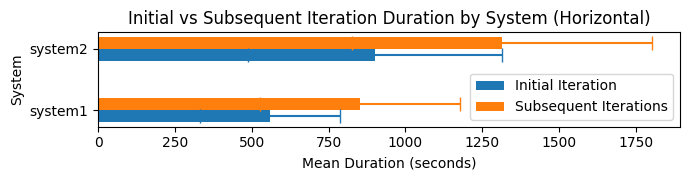

In [41]:
# Rotated (horizontal) version of plot_initial_vs_other_stats
def plot_initial_vs_other_stats_horizontal(initial_csv, other_csv, out_path=None):
    import pandas as pd
    import matplotlib.pyplot as plt
    df_init = pd.read_csv(initial_csv)
    df_other = pd.read_csv(other_csv)
    systems = df_init["system_type"].tolist()
    y = np.arange(len(systems))
    height = 0.2
    fig, ax = plt.subplots(figsize=(7, 0.7*len(systems)+0.5))
    # Horizontal bars
    ax.barh(y - height/2, df_init["mean"], height, label="Initial Iteration", color="#1f77b4")
    ax.barh(y + height/2, df_other["mean"], height, label="Subsequent Iterations", color="#ff7f0e")
    # Error bars (std or ci95)
    err_init = df_init["std"] if "std" in df_init.columns else df_init.get("ci95", 0)
    err_other = df_other["std"] if "std" in df_other.columns else df_other.get("ci95", 0)
    ax.errorbar(df_init["mean"], y - height/2, xerr=err_init, fmt="none", capsize=5, color="#1f77b4")
    ax.errorbar(df_other["mean"], y + height/2, xerr=err_other, fmt="none", capsize=5, color="#ff7f0e")
    ax.set_yticks(y)
    ax.set_yticklabels(systems)
    ax.set_xlabel("Mean Duration (seconds)")
    ax.set_ylabel("System")
    ax.set_title("Initial vs Subsequent Iteration Duration by System (Horizontal)")
    ax.legend()
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=150)
        print(f"Saved plot: {out_path}")
    plt.show()

# Example usage:
plot_initial_vs_other_stats_horizontal(
    "result/time/system_duration_stats_initial.csv",
    "result/time/system_duration_stats_other.csv",
    "result/time/plot_initial_vs_other_duration_horizontal.png"
)